Project #5: Video Stitching and Processing 

https://courses.grainger.illinois.edu/cs445/sp2025/projects/video/ComputationalPhotograph_ProjectVideo.html

## CS445: Computational Photography

### Setup


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# modify to where you store your project data including utils
datadir = "/home/tars/Projects/UIUC-Computational-Photography/Project_5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

cp: '/home/tars/Projects/UIUC-Computational-Photography/Project_5/utils.py' and './utils.py' are the same file
cp: '/home/tars/Projects/UIUC-Computational-Photography/Project_5/images' and './images' are the same file


In [12]:
# !pip uninstall opencv-python -y
# # downgrade OpenCV a bit to use SIFT
# # !pip install opencv-contrib-python==4.5.5.64 --force-reinstall
!pip install opencv-contrib-python==4.9.0.80
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [13]:
def auto_homography(Ia, Ib, homography_func=None, niter=1000):
    '''
    Computes a homography that maps points from Ia to Ib

    Outputs H, the best homography matrix from the iterations

    So, what are we really doing here?

    Well, we will define our homography function later and pass it into this function, but the idea in general is
    to find the homography matrix (matrix that maps points from one place to another) that best maps points from
    image Ia to image Ib. 

    How do we do it?

    (1) computing homography H between frame 450 and each other frame
    (2) projecting each frame onto the same surface
    (3) blend the surfaces
    
    '''

    Ia_gray = cv2.cvtColor(Ia, cv2.COLOR_BGR2GRAY)                    # Convert images to grayscale because SIFT does not use
                                                                      # color, but rather intensity values
    Ib_gray = cv2.cvtColor(Ib, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()                                          # Init the sift detector

    kp_a, des_a = sift.detectAndCompute(Ia_gray, None)                # Find the keypoints and descriptors with SIFT
    kp_b, des_b = sift.detectAndCompute(Ib_gray, None)

    bf = cv2.BFMatcher()                                              # BFMatcher with default parameters. We are just getting
                                                                      # the matches of keypoints between our two images
    matches = bf.knnMatch(des_a, des_b, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:                            # Apply ratio test. We only will take instances where the 
                                                                      # best and second best matches are within a threshold,
                                                                      # and we consider those as "good"
            good.append(m)

    numMatches = len(good)
    
    Xa = np.ones((3, numMatches))                                                                                                     
    Xb = np.ones((3, numMatches))                                     # Xa and Xb are 3xN matrices that contain homogeneous coordinates 
                                                                      # for the N matching points for each image. We need these because
                                                                      # of the transformation we are trying to compute between the 2 images
    
    for idx, match_i in enumerate(good):
        Xa[:, idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:, idx][0:2] = kp_b[match_i.trainIdx].pt

    best_score = 0                                                    # RANSAC:randomly select a small number of points to estimate the homogrpahy
    best_H = None
    best_inliers = None

    for _ in range(niter):
        subset = np.random.choice(numMatches, 4, replace=False)       # Randomly select 4 points for homography estimation
        pts1 = Xa[:, subset]
        pts2 = Xb[:, subset]

        H_t = homography_func(pts1, pts2)                             # Compute homography using the provided function

        Xb_ = np.dot(H_t, Xa)                                         # Project points from first image to second image using the estimated homography
        du = Xb_[0, :] / Xb_[2, :] - Xb[0, :] / Xb[2, :]
        dv = Xb_[1, :] / Xb_[2, :] - Xb[1, :] / Xb[2, :]

        ok_t = np.sqrt(du**2 + dv**2) < 0.67                          # Compute distances and inliers
        score_t = np.sum(ok_t)

        if score_t > best_score:                                      # Update the best homography if this one is better
            best_score = score_t
            best_H = H_t
            best_inliers = ok_t

    print(f'Best score: {best_score:.2f}')

    return best_H, best_inliers

def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver

    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous coordinates.
    Output: H is a 3x3 matrix, such that pts2 ~= H * pts1

    This is just the homography function we are passing into auto_homography()

    It will be called in the loop section of auto_homography(), such that we call
    it for the random points we select, and replace the result if we find a better
    homography
    '''
    N = pts1.shape[1]

    A = np.zeros((2 * N, 9))
    for i in range(N):                                                # For each pair of corresponding points, we get two 
                                                                      # equations 
        A[2 * i, :] = [-pts1[0, i], -pts1[1, i], -1, 0, 0, 0, pts1[0, i] * pts2[0, i], pts1[1, i] * pts2[0, i], pts2[0, i]]
        A[2 * i + 1, :] = [0, 0, 0, -pts1[0, i], -pts1[1, i], -1, pts1[0, i] * pts2[1, i], pts1[1, i] * pts2[1, i], pts2[1, i]]

    _, _, V = svd(A)                                                  # Then we just solve with SVD and extract the homography
    h = V[-1, :]
    H = np.reshape(h, (3, 3))

    return H

Best score: 112.00
[[-4.85612987e-03 -2.88038651e-04  1.00000000e+00]
 [-7.32621183e-05 -4.65339342e-03  8.17715385e-02]
 [-1.89565324e-06 -4.18223779e-07 -3.91305648e-03]]


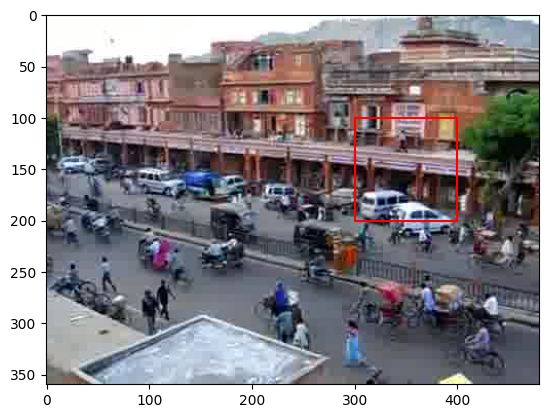

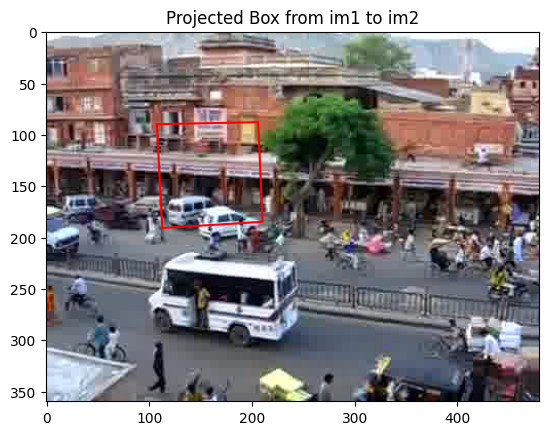

In [14]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

# Get the homography and inliers using the auto_homography function
H, inliers = auto_homography(im1, im2, homography_func=computeHomography, niter=1000)

# H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2

# Project box_pts from im1 to im2 using the homography H
projected_pts = H @ box_pts
projected_pts /= projected_pts[2, :]  # Normalize homogeneous coordinates

# Plot the projected box on im2
plt.figure()
plt.imshow(im2[:, :, [2, 1, 0]])  # Convert BGR to RGB
plt.plot(projected_pts[0, :], projected_pts[1, :], 'r-')
plt.title('Projected Box from im1 to im2')
plt.show()

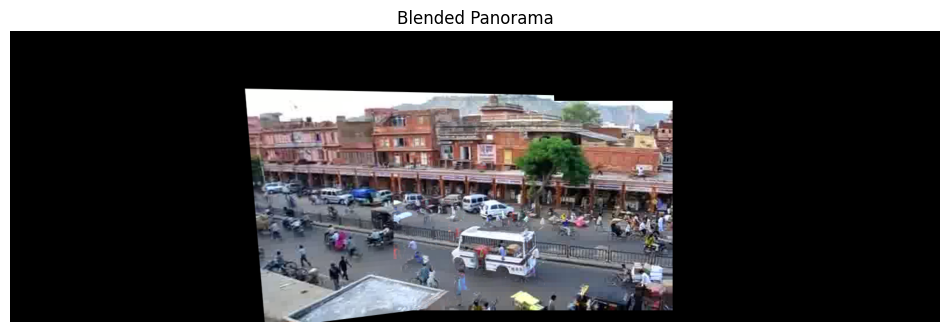

In [15]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images

Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float64)             # Make sure Tr is float64.. translation matrix

H_warp = Tr @ H.astype(np.float64)                                                 # Compose the warp homography.. combines the two transformations

im1_warped = cv2.warpPerspective(im1, H_warp, (projectedWidth, projectedHeight))   # Warp images
im2_warped = cv2.warpPerspective(im2, Tr, (projectedWidth, projectedHeight))

blended = np.maximum(im1_warped, im2_warped)                                       # Blend using per pixel max

plt.figure(figsize=(12, 6))
plt.imshow(blended[:, :, [2, 1, 0]])
plt.title("Blended Panorama")
plt.axis('off')
plt.show()

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


Best score: 48.00
Best score: 115.00
Best score: 79.00
Best score: 37.00


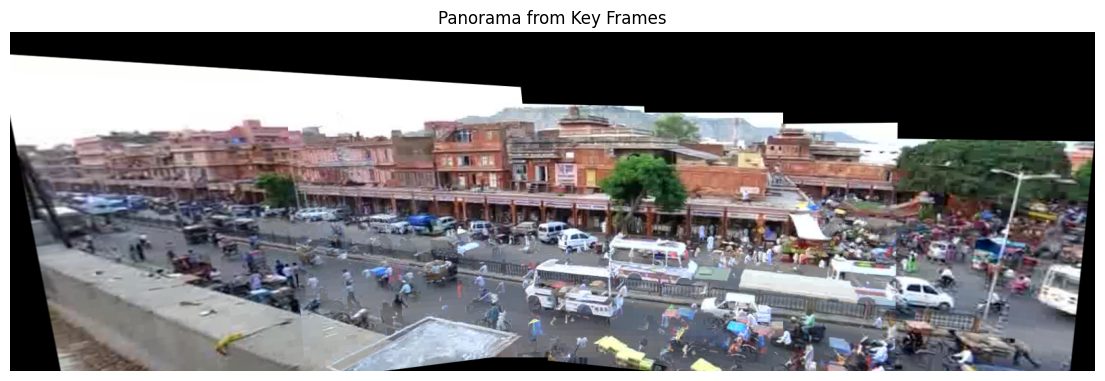

In [7]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1
ref_idx = 2  # index of frame 450 in key_frames_idx

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

# Parameters
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float64)

# Homography chain: we store the homography from each frame to the reference (450)
homographies = []

for i, frame in enumerate(frames):
    if i == ref_idx:
        homographies.append(np.eye(3))  # Identity for the reference frame
    else:
        # Compute homography from frame i to reference frame
        H, _ = auto_homography(frames[i], frames[ref_idx], homography_func=computeHomography, niter=1000)
        H = H.astype(np.float64)
        homographies.append(H)

# Initialize a blank canvas for blending
canvas = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)

for i, (frame, H) in enumerate(zip(frames, homographies)):
    H_warp = Tr @ H
    warped = cv2.warpPerspective(frame, H_warp, (projectedWidth, projectedHeight))
    
    # Simple max blending
    canvas = np.maximum(canvas, warped)

# Display the panorama
plt.figure(figsize=(14, 6))
plt.imshow(canvas[:, :, [2, 1, 0]])
plt.title("Panorama from Key Frames")
plt.axis("off")
plt.show()



### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [8]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)



In [ ]:
# TO DO part 3 solution

# create your video (see tips)

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [ ]:
# TO DO part 4

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [ ]:
# TO DO part 5



### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6


## Bells and whistles